# Exponential Model

This notebook contains the simplest model (an exponential) that captures the behavior of the virus responsible for covid.  It uses an exponential function

$$\textrm{Cumulative Infections} = \textrm{Initial Infections}\cdot e^{\textrm{Growth Rate}\cdot t}$$

It does not consider

- A reducing pool of susceptible individuals slowing the growth rate
- An social distancing behaviors in the future

It only finds the growth rate for the current US data and continues that trend into the future.

We are currently doubling our number of cases every 2.4 days and the growth rate appears steady.

If our social distancing strategies are effective, the slope of the dots will decrease showing a slowing of transmission.

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import requests
import json

In [2]:
# get US positive observations from covidtracking.com
URL = 'https://covidtracking.com/api/us/daily'
r = requests.get(URL)
data = pd.read_json(json.dumps(r.json()))

# wrangle dates
data.index = data['date']
data.index = pd.to_datetime(data['date'], format='%Y%m%d')
del(data['date'])

# display data
data.head()



,states,positive,negative,posNeg,pending,hospitalized,death,total
date,,,,,,,,
2020-03-23,56,42164,237321,279485,14571,3325.0,471.0,294056
2020-03-22,56,31888,193463,225351,2842,2554.0,398.0,228216
2020-03-21,56,23203,155909,179112,3477,1964.0,272.0,182589
2020-03-20,56,17038,118147,135185,3336,NaN,219.0,138521
2020-03-19,56,11723,89119,100842,3025,NaN,160.0,103867


In [3]:
def plot_for(column, color):
    # clean data
    # vd valid data
    vd = data[column].dropna()
    # sort by date
    vd.sort_index(inplace=True)

    # create independent variable of days since start of data
    days = (vd.index - vd.index[0]) / np.timedelta64(1, 'D')

    # take log of independent variable
    log_vd = np.log(vd.values)

    # shift dates or find first date

    # find least-squares fit coefficients
    beta, log_initial = np.polyfit(days, log_vd, 1)

    # create vector of extrapolated positive cases
    num_days = 10
    time = np.arange(0, len(vd.index) + num_days, 1)
    extrapolated_positives = np.exp(log_initial) * np.exp(beta * time)

    # put in pandas series with dates for easy plotting
    extrapolation_dates = [vd.index[0] + np.timedelta64(1, 'D') * t for t in time]
    extrapolation = pd.Series(index=extrapolation_dates, data=extrapolated_positives)
    
    ax.plot(vd.index, vd, marker='o', linestyle='', color=color, label=column)
    ax.plot(extrapolation.index, extrapolation, color=color, alpha=0.2)
    
    return {'time_constant':1/beta, 'initial':np.exp(log_initial), 'first_date':vd.index[0], 'column':column}

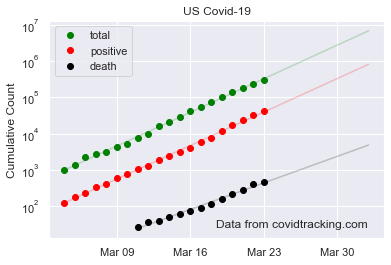

In [4]:
import seaborn as sns
from matplotlib.dates import MO
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

sns.set()
fig, ax = plt.subplots()

loc = mdates.WeekdayLocator(byweekday=MO)
ax.xaxis.set_major_locator(loc)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
ax.set_title('US Covid-19')
ax.set_yscale('log')
ax.text(0.5, 0.05, 'Data from covidtracking.com', transform=ax.transAxes)
ax.grid(True)
ax.set_ylabel('Cumulative Count')
results = []
for column, color in zip(*(['total', 'positive', 'death'], ['green', 'red', 'black'])):
    results.append(plot_for(column, color))
    
ax.legend()
plt.show()

In [5]:
results_df = pd.DataFrame(results)
results_df['days to double'] = np.log(2) * results_df['time_constant']
results_df['days to 10x'] = np.log(10) * results_df['time_constant']
results_df.index = results_df['column']
del(results_df['column'])

results_df

,time_constant,initial,first_date,days to double,days to 10x
column,,,,,
total,3.274886,986.947438,2020-03-04,2.269978,7.540704
positive,3.291241,122.530667,2020-03-04,2.281315,7.578363
death,4.150798,24.213553,2020-03-11,2.877114,9.557567
